# Sarcasm Detection using Tensorflow - Bidirectional LSTMs and Convolutional 1D

Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.

This new dataset has following advantages over the existing Twitter datasets:

Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.

Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

Unlike tweets which are replies to other tweets, the news headlines we obtained are self-contained. This would help us in teasing apart the real sarcastic elements.

**Content**
Each record consists of three attributes:

is_sarcastic: 1 if the record is sarcastic otherwise 0

headline: the headline of the news article

article_link: link to the original news article. Useful in collecting supplementary data

***
The concept is to perform tokenizing the words to get numeric values from them and then using Embeddings to group words of similar meaning,
depending on how they are labelled resulting in a good but rough sentiment analysis
***

In [8]:
# Library imports

import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
# Load the json data

def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

datastore = list(parse_data('resources/Sarcasm_Headlines_Dataset.json'))

# define the attribues from the json data
sentences = []
labels = []
urls = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [3]:
# Define some global constants
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<oov>"
training_size = 20000

In [4]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [5]:
# Build the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [6]:
# Build the LSTM model and compile
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_________________________________________________________________


In [7]:
# fit on the training data
num_epochs = 50
training_padded = np.array(training_padded)
testing_padded = np.array(testing_padded)
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/50
625/625 [==============================] - 17s 22ms/step - loss: 0.4499 - accuracy: 0.7713 - val_loss: 0.3920 - val_accuracy: 0.8231
Epoch 2/50
625/625 [==============================] - 14s 22ms/step - loss: 0.3484 - accuracy: 0.8415 - val_loss: 0.3743 - val_accuracy: 0.8249
Epoch 3/50
625/625 [==============================] - 13s 21ms/step - loss: 0.3277 - accuracy: 0.8522 - val_loss: 0.3797 - val_accuracy: 0.8216
Epoch 4/50
625/625 [==============================] - 14s 22ms/step - loss: 0.3122 - accuracy: 0.8607 - val_loss: 0.3732 - val_accuracy: 0.8331
Epoch 5/50
625/625 [==============================] - 13s 22ms/step - loss: 0.3029 - accuracy: 0.8658 - val_loss: 0.3770 - val_accuracy: 0.8343
Epoch 6/50
625/625 [==============================] - 12s 20ms/step - loss: 0.2953 - accuracy: 0.8701 - val_loss: 0.3782 - val_accuracy: 0.8313
Epoch 7/50
625/625 [==============================] - 12s 20ms/step - loss: 0.2858 - accuracy: 0.8732 - val_loss: 0.3784 - val_accuracy:

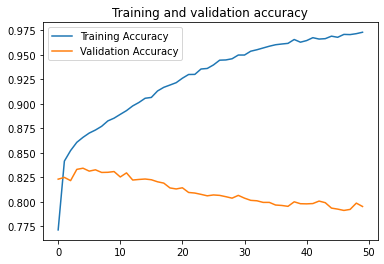

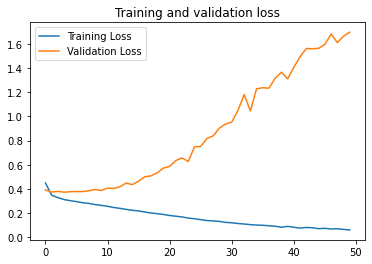

In [9]:
# lets evaluate the accuracy and loss
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs, acc, label='Training Accuracy' )
plt.plot  ( epochs, val_acc, label='Validation Accuracy' )
plt.title ('Training and validation accuracy')
plt.legend()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs, loss, label='Training Loss' )
plt.plot  ( epochs, val_loss, label='Validation Loss' )
plt.title ('Training and validation loss'   )
plt.legend()
plt.show()

In [10]:
# Build the Conv1D model and compile

model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation=tf.nn.relu),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 29,489
Trainable params: 29,489
Non-trainable params: 0
_________________________________________________________________


In [12]:
# fit on the training data
history_conv = model_conv.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/50
625/625 [==============================] - 3s 4ms/step - loss: 0.0173 - accuracy: 0.9924 - val_loss: 2.4529 - val_accuracy: 0.7727
Epoch 2/50
625/625 [==============================] - 3s 4ms/step - loss: 0.0265 - accuracy: 0.9888 - val_loss: 2.5210 - val_accuracy: 0.7778
Epoch 3/50
625/625 [==============================] - 3s 4ms/step - loss: 0.0212 - accuracy: 0.9908 - val_loss: 2.5501 - val_accuracy: 0.7778
Epoch 4/50
625/625 [==============================] - 3s 4ms/step - loss: 0.0162 - accuracy: 0.9923 - val_loss: 2.5956 - val_accuracy: 0.7758
Epoch 5/50
625/625 [==============================] - 3s 4ms/step - loss: 0.0181 - accuracy: 0.9915 - val_loss: 2.6365 - val_accuracy: 0.7787
Epoch 6/50
625/625 [==============================] - 3s 4ms/step - loss: 0.0185 - accuracy: 0.9917 - val_loss: 2.6698 - val_accuracy: 0.7761
Epoch 7/50
625/625 [==============================] - 3s 4ms/step - loss: 0.0202 - accuracy: 0.9908 - val_loss: 2.7285 - val_accuracy: 0.7784
Epoch 

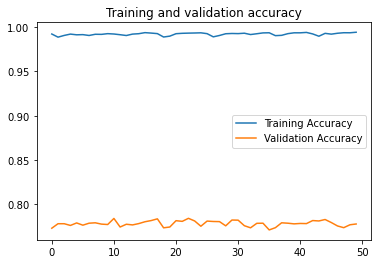

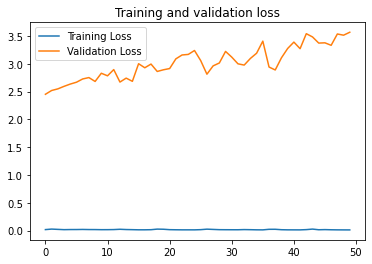

In [13]:
# lets evaluate the accuracy and loss
acc      = history_conv.history['accuracy']
val_acc  = history_conv.history['val_accuracy']
loss     = history_conv.history['loss']
val_loss = history_conv.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs, acc, label='Training Accuracy' )
plt.plot  ( epochs, val_acc, label='Validation Accuracy' )
plt.title ('Training and validation accuracy')
plt.legend()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs, loss, label='Training Loss' )
plt.plot  ( epochs, val_loss, label='Validation Loss' )
plt.title ('Training and validation loss'   )
plt.legend()
plt.show()